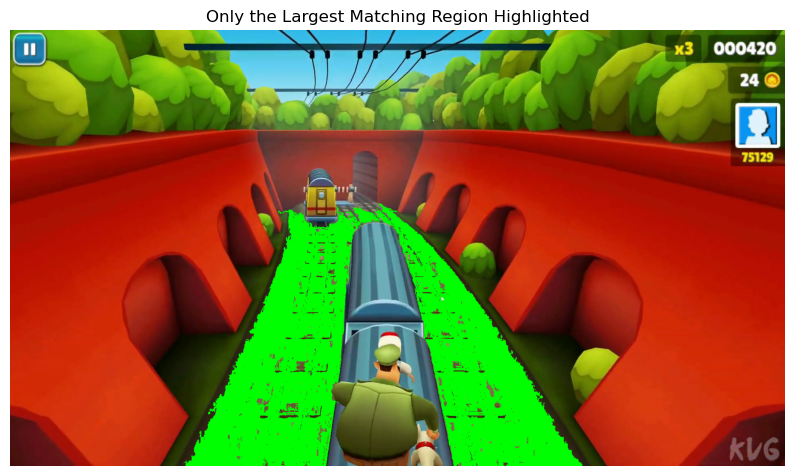

Total time: 0.3763 seconds


In [123]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def build_3d_lut(img1, tol=0.10):
    """
    Build a 256×256×256 boolean LUT marking any RGB within ±tol of
    any colour in img1.
    """
    cols = np.unique(img1.reshape(-1, 3), axis=0).astype(np.int16)
    lut  = np.zeros((256, 256, 256), dtype=bool)
    for r, g, b in cols:
        lo_r = max(0,   int(r * (1 - tol))); hi_r = min(255, int(r * (1 + tol)))
        lo_g = max(0,   int(g * (1 - tol))); hi_g = min(255, int(g * (1 + tol)))
        lo_b = max(0,   int(b * (1 - tol))); hi_b = min(255, int(b * (1 + tol)))
        lut[lo_r:hi_r+1, lo_g:hi_g+1, lo_b:hi_b+1] = True
    return lut

def highlight_with_lut_keep_largest(img2, lut, highlight=(0,255,0)):
    """
    Apply the LUT to img2, then keep only the single largest connected
    True region in the mask, recoloring that to `highlight`.
    """
    # 1) raw boolean mask from LUT
    mask = lut[img2[...,0], img2[...,1], img2[...,2]].astype(np.uint8)

    # 2) connected components (background=0)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        mask, connectivity=8
    )
    # stats[:, cv2.CC_STAT_AREA] holds area for each label
    # skip label 0 (background)
    if n_labels <= 1:
        # nothing detected
        filtered = np.zeros_like(mask, dtype=bool)
    else:
        areas = stats[1:, cv2.CC_STAT_AREA]
        max_idx = 1 + int(np.argmax(areas))
        filtered = (labels == max_idx)

    # 3) overlay highlight
    out = img2.copy()
    out[filtered] = highlight
    return out

# ——— Usage ———
start = time.time()
img1 = cv2.cvtColor(cv2.imread("BLAH.png"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("train_screenshots/frame_0004.jpg"), cv2.COLOR_BGR2RGB)

lut    = build_3d_lut(img1, tol=0.04)
result = highlight_with_lut_keep_largest(img2, lut, highlight=(0,255,0))

plt.figure(figsize=(10,8))
plt.imshow(result)
plt.axis('off')
plt.title("Only the Largest Matching Region Highlighted")
plt.show()

end = time.time()

print(f"Total time: {end - start:.4f} seconds")


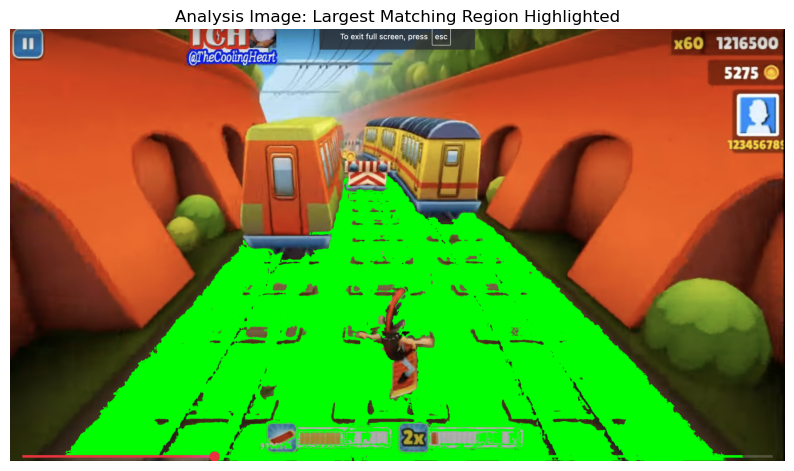

Total time: 0.6207 seconds


In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def build_3d_lut(images, tol=0.10):
    """
    Build a 256×256×256 boolean LUT marking any RGB within ±tol of
    any colour in any image in `images`.

    Args:
      images: list of H×W×3 uint8 RGB arrays to sample colours from
      tol:    relative tolerance (e.g. 0.04 for ±4%)

    Returns:
      lut:    (256,256,256) bool array where lut[r,g,b] == True
              if (r,g,b) is within ±tol of any sampled colour
    """
    # 1) collect unique colours from all setup images
    cols_list = []
    for img in images:
        # reshape to list of RGB triples and uniquify
        u = np.unique(img.reshape(-1, 3), axis=0)
        cols_list.append(u.astype(np.int16))
    # stack and dedupe
    cols = np.vstack(cols_list)
    cols = np.unique(cols, axis=0)

    # 2) allocate the LUT
    lut = np.zeros((256, 256, 256), dtype=bool)

    # 3) mark each colour’s ±tol box
    for r, g, b in cols:
        lo_r = max(0,   int(r * (1 - tol))); hi_r = min(255, int(r * (1 + tol)))
        lo_g = max(0,   int(g * (1 - tol))); hi_g = min(255, int(g * (1 + tol)))
        lo_b = max(0,   int(b * (1 - tol))); hi_b = min(255, int(b * (1 + tol)))
        lut[lo_r:hi_r+1, lo_g:hi_g+1, lo_b:hi_b+1] = True

    return lut

def highlight_with_lut_keep_largest(img, lut, highlight=(0,255,0)):
    """
    Apply the LUT to `img`, keep only the largest connected True region,
    and recolor it into `highlight`.
    """
    # raw mask via one-shot LUT lookup
    mask = lut[img[...,0], img[...,1], img[...,2]].astype(np.uint8)

    # connected components to find largest blob
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if n_labels <= 1:
        filtered = np.zeros_like(mask, dtype=bool)
    else:
        areas = stats[1:, cv2.CC_STAT_AREA]
        max_idx = 1 + int(np.argmax(areas))
        filtered = (labels == max_idx)

    # overlay neon highlight
    out = img.copy()
    out[filtered] = highlight
    return out


start = time.time()

# ——— Usage ———
# load your two setup images (img1 & img2)
img1 = cv2.cvtColor(cv2.imread("rails1.png"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("rails2.png"), cv2.COLOR_BGR2RGB)
# load the analysis image (img3)
img3 = cv2.cvtColor(cv2.imread("test10-1.png"), cv2.COLOR_BGR2RGB) #Adjust

# build LUT from setup images
lut = build_3d_lut([img1, img2], tol=0.04)

# apply to img3 and keep only the largest match
result = highlight_with_lut_keep_largest(img3, lut, highlight=(0,255,0))

# display
plt.figure(figsize=(10,8))
plt.imshow(result)
plt.axis('off')
plt.title("Analysis Image: Largest Matching Region Highlighted")
plt.show()

end = time.time()

print(f"Total time: {end - start:.4f} seconds")


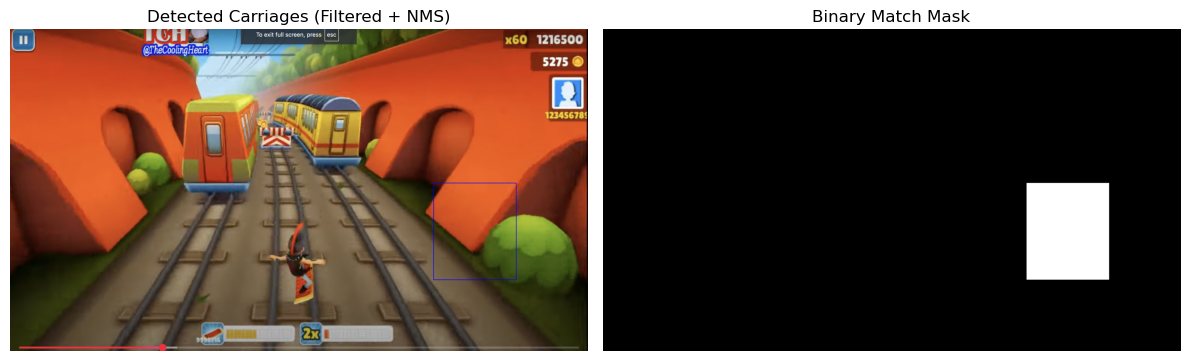

In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def non_max_suppression_fast(boxes, scores, overlapThresh=0.3):
    if len(boxes) == 0:
        return [], []

    boxes = np.array(boxes)
    scores = np.array(scores)
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]

    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[1:]]

        idxs = idxs[np.where(overlap <= overlapThresh)[0] + 1]

    return boxes[pick], scores[pick]


def template_match_and_highlight(
    test_img_path,
    template_img_path,
    threshold=0.8,
    min_y_ratio=0.3,
    min_x_ratio=0.1,
    max_x_ratio=0.9,
    aspect_ratio_range=(0.8, 3.0),
    nms_overlap=0.3
):
    """
    Template matching with NMS and full geometry filtering.
    """
    img_rgb = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    template_rgb = cv2.cvtColor(cv2.imread(template_img_path), cv2.COLOR_BGR2RGB)
    template_gray = cv2.cvtColor(template_rgb, cv2.COLOR_BGR2GRAY)
    h, w = template_gray.shape

    # Match
    res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)
    scores = res[loc]

    raw_boxes = [(x, y, w, h) for (x, y) in zip(*loc[::-1])]

    # NMS
    boxes, kept_scores = non_max_suppression_fast(raw_boxes, scores, overlapThresh=nms_overlap)

    # Geometry filtering
    h_img, w_img = img_rgb.shape[:2]
    y_thresh = h_img * min_y_ratio
    x_min = w_img * min_x_ratio
    x_max = w_img * max_x_ratio

    filtered_boxes = []
    for (x, y, w, h), score in zip(boxes, kept_scores):
        aspect = w / (h + 1e-5)
        if (
            y > y_thresh and
            x > x_min and
            (x + w) < x_max and
            aspect_ratio_range[0] <= aspect <= aspect_ratio_range[1]
        ):
            filtered_boxes.append((x, y, w, h))

    # Draw results
    match_img = img_rgb.copy()
    match_mask = np.zeros_like(img_gray, dtype=np.uint8)

    for (x, y, w, h) in filtered_boxes:
        cv2.rectangle(match_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
        match_mask[y:y+h, x:x+w] = 255

    return match_img, match_mask


# ——— Run the detection ———
if __name__ == "__main__":
    test_img = "test10-1.png"
    template_img = "face1.png"

    result_img, mask = template_match_and_highlight(
        test_img_path=test_img,
        template_img_path=template_img,
        threshold=0.40,
        min_y_ratio=0.3,          # Ignore matches above this % of image height
        min_x_ratio=0.1,          # Ignore matches left of this % of width
        max_x_ratio=0.9,          # Ignore matches right of this % of width
        aspect_ratio_range=(0.8, 3.0),
        nms_overlap=0.7
    )

    # Show result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("Detected Carriages (Filtered + NMS)")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Binary Match Mask")

    plt.tight_layout()
    plt.show()
